DATA PREPROCESSING

In [13]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
from pathlib import Path


user = ''

figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_5/figures'


# Define the path to the directory containing the CSV files
data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_5/data')


df_OIS_swaps = pd.read_csv(f'{data_path}/OIS_swap_rates.csv')

df_treasury_yields = pd.read_csv(f'{data_path}/treasury_yields.csv')

df_tp = pd.read_csv(f'{data_path}/ACM.csv')

df_tp = df_tp[['Date', 'ACMTP10']]

df_tp.rename(columns={'ACMTP10': '10yr_tp'}, inplace=True)

df_tp['Date'] = pd.to_datetime(df_tp['Date'])

df_OIS_swaps['Date'] = pd.to_datetime(df_OIS_swaps['Date'])

df_OIS_swaps.loc[:, df_OIS_swaps.columns != "Date"] *= 1000


df_treasury_yields['Date'] = pd.to_datetime(df_treasury_yields['Date'])

df_total = pd.merge(df_OIS_swaps, df_treasury_yields, on='Date', how='inner')

df_total = pd.merge(df_total, df_tp, on='Date', how='inner')

df_total.rename(columns={'7yr_yield ': '7yr_yield'}, inplace=True)
df_total.sort_values(by='Date', ascending=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

df_total['10yr_tp'] = df_total['10yr_tp']*100

df_total['1y6m_OIS_swap'] = ((1+0.5*df_total['1yr_OIS_swap'] + 0.5*df_total['2yr_OIS_swap'])/(1+df_total['6m_OIS_swap'])**0.5)**2 - 1

df_total['1y1y_OIS_swap'] = ((1+df_total['2yr_OIS_swap'])**2/(1+df_total['1yr_OIS_swap'])) - 1

df_total['ffr_curve'] = (df_total['1y1y_OIS_swap'] - df_total['1yr_OIS_swap']) 

df_total['ffr_curve'] = df_total['ffr_curve'].abs()

df_total['aged'] = df_total['ffr_curve'].shift(90)

df_total.dropna(inplace=True)

df_total['curve'] = df_total['10yr_OIS_swap'] - df_total['2yr_OIS_swap']




<>:82: SyntaxWarning: invalid escape sequence '\ '
<>:82: SyntaxWarning: invalid escape sequence '\ '
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_67525/3140313191.py:82: SyntaxWarning: invalid escape sequence '\ '
  ' * Fed funds curve is defined as the 1y1y \ 2y1y OIS swap curve \n\n'


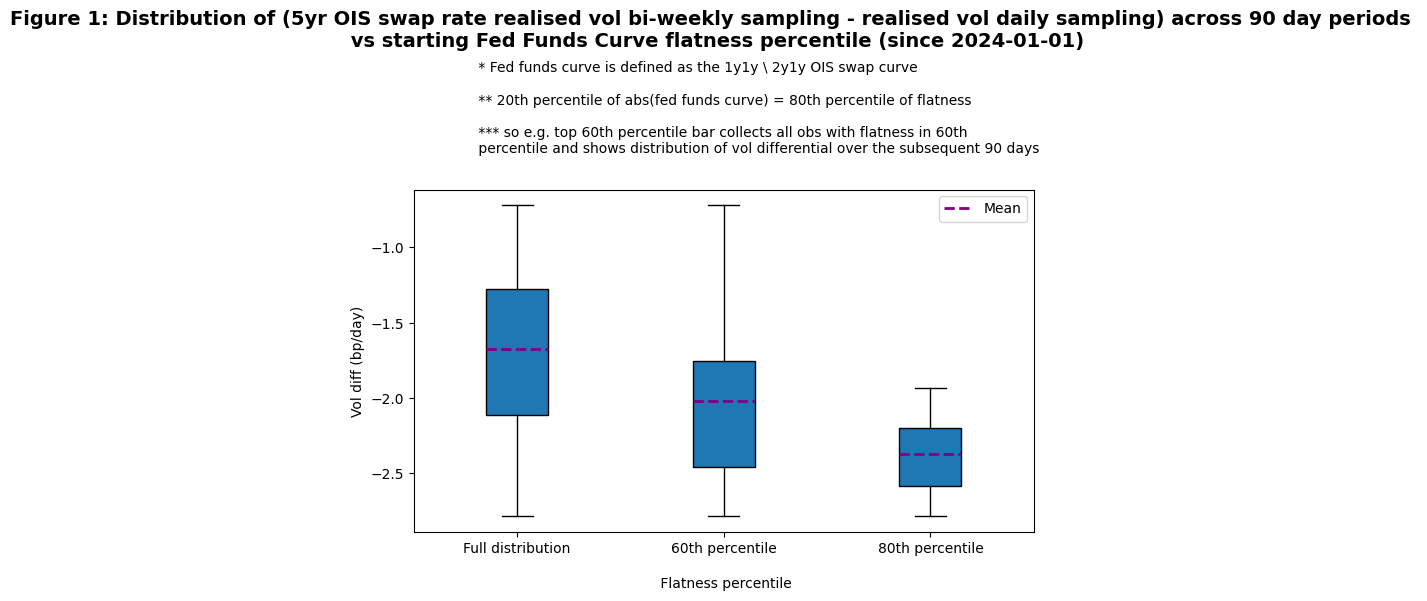

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_vol_diff_boxplot(df, date_col, ois_col, aged_col, start_date, end_date, custom_subtitle=""):
    """
    Computes realized volatilities (daily and bi-weekly), calculates vol_diff, segments based on z-score distribution, 
    and plots a boxplot of vol_diff for the Full distribution, Top 60%, and Top 80% z-score groups.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing relevant columns.
    date_col (str): The name of the date column.
    ois_col (str): The name of the 5-year OIS swap column.
    aged_col (str): The name of the aged variable for z-score calculation.
    start_date (str): The start date for filtering observations (format: 'YYYY-MM-DD').
    end_date (str): The end date for filtering observations (format: 'YYYY-MM-DD').
    custom_subtitle (str): Custom subtitle to display below the main title.

    Returns:
    None (Displays a boxplot)
    """

    df = df.copy()

    # Convert date column to datetime if not already
    df[date_col] = pd.to_datetime(df[date_col])

    # Filter data for the specified date range
    df = df[(df[date_col] >= pd.to_datetime(start_date)) & (df[date_col] <= pd.to_datetime(end_date))]

    # Compute rolling realized volatilities
    df['RV_daily'] = df[ois_col].rolling(90).std()
    df['RV_biweekly'] = df[ois_col].rolling(90).apply(lambda x: np.std(x[::15]), raw=True) / np.sqrt(15)

    # Compute the difference in realized volatility
    df['vol_diff'] = df['RV_biweekly'] - df['RV_daily']

    # Compute z-score for 'aged' variable
    df['z_score'] = (df[aged_col] - df[aged_col].mean()) / df[aged_col].std()

    # Compute quantiles for segmentation
    quantiles = df['z_score'].quantile([0.20, 0.30, 0.40, 0.50, 1])

    # Drop NaNs in vol_diff
    df = df.dropna(subset=['vol_diff'])

    # Define the groups
    groups = {
        "Full distribution": df.loc[df['z_score'] <= quantiles[1], 'vol_diff'],
        "60th percentile": df.loc[df['z_score'] <= quantiles[0.4], 'vol_diff'],
        "80th percentile": df.loc[df['z_score'] <= quantiles[0.2], 'vol_diff'],
    }

    # Create boxplot
    plt.figure(figsize=(8, 6))

    # Plot manually specified groups
    boxplot = plt.boxplot(
        groups.values(),
        patch_artist=True,
        showfliers=False,  # Hide outliers
        showmeans=True,    # Show mean line
        meanline=True,
        medianprops=dict(visible=False),
        meanprops={"color": "purple", "linewidth": 2, "linestyle": "dashed"}
    )

    # Custom x-axis labels
    plt.xticks(range(1, len(groups) + 1), groups.keys())

    # Add legend for mean line
    plt.plot([], [], color="purple", linewidth=2, linestyle="dashed", label="Mean")
    plt.legend(loc="upper right")

    # Add title and subtitle
    plt.suptitle("Figure 1: Distribution of (5yr OIS swap rate realised vol bi-weekly sampling - realised vol daily sampling) across 90 day periods \n vs starting Fed Funds Curve flatness percentile (since 2024-01-01)", 
             fontsize=14, fontweight='bold')

    plt.title(custom_subtitle, fontsize=10, fontweight='normal')

    plt.figtext(0.2, 0.66, 
            ' * Fed funds curve is defined as the 1y1y \ 2y1y OIS swap curve \n\n'
            ' ** 20th percentile of abs(fed funds curve) = 80th percentile of flatness \n\n'
            ' *** so e.g. top 60th percentile bar collects all obs with flatness in 60th \n percentile and shows distribution of vol differential over the subsequent 90 days \n\n\n')

    # Adjust spacing to make more room for the subtitle
    plt.subplots_adjust(top=0.68)  # Reduce this value to push the graph lower

    # Add labels
    plt.xlabel("\n Flatness percentile")
    plt.ylabel("Vol diff (bp/day)")

    # Save and show plot
    plt.savefig(f'{figure_path}/figure1.jpg', format='jpeg', bbox_inches='tight')
    plt.show()  

    # Show plot
    plt.show()


# Example usage with a subtitle:
plot_vol_diff_boxplot(df_total, 'Date', '5yr_OIS_swap', 'aged', '2024-01-01', '2025-02-20')



